In [ ]:
import getpass
import os

In [ ]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f'{var}: ')

In [ ]:
_set_env("OPENAI_API_KEY")

In [ ]:
!pip install langgraph

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

In [ ]:
!pip install langchain_openai

In [ ]:
from langchain_openai import ChatOpenAI

In [ ]:
llm = ChatOpenAI(model='gpt-5-nano')

In [ ]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state['messages'])]}

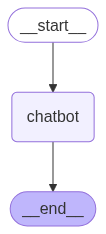

In [ ]:
graph_builder.add_node('chatbot', chatbot)

graph_builder.add_edge(START, 'chatbot')
graph_builder.add_edge('chatbot', END)

graph = graph_builder.compile()

graph

In [ ]:
def stream_graph_update(user_input: str):
    for event in graph.stream({'messages': [{'role': 'user', 'content': user_input}]}):
        for value in event.values():
            print('Assistant: ', value['messages'][-1].content)

In [ ]:
while True:
    user_input = input('User: ')
    if user_input.lower() in ['quit', 'exit', 'q']:
        print("프로그램을 종료합니다.")
        break
    stream_graph_update(user_input)

User: hello?
Assistant:  Hello! How can I help you today? I can answer questions, explain topics, help with writing or editing, brainstorm ideas, assist with coding, translate or summarize text, plan tasks, or just chat. What would you like to start with?
User: 한국말로 해줘
Assistant:  네, 한국말로 도와드리겠습니다. 어떤 도움이 필요하신가요? 예시로는

- 궁금한 점 설명이나 정보 확인
- 글쓰기나 번역 다듬기
- 코드나 알고리즘 설명
- 공부 계획이나 문제 풀이 방법
- 여행 정보나 맛집 추천
- 생활 팁이나 의사결정 도와주기

원하는 주제나 질문을 말씀해주시면 바로 도와드리겠습니다.
User: 생활 팁
Assistant:  좋아요! 다양한 상황에 쓸 수 있는 생활 팁을 정리해드릴게요. 필요하신 영역이 있으면 알려주시면 그에 맞춰 더 자세히 드리겠습니다.

- 일상 루틴
  - 매일 같은 시간에 일어나고 잠자기: 생체리듬 안정에 도움
  - 물 한 잔으로 하루 시작하기, 하루 목표 1~3개만 확정
  - 15분 정리 타임: 공간/일거리 간단 정리로 생산성 상승

- 건강 및 체력
  - 물 약 2리터 목표로 마시기
  - 하루 걷기 20–30분, 주 3회 가벼운 운동
  - 충분한 수면: 일정한 취침/기상 시간 유지

- 식사 및 다이어트
  - 주간 메뉴 계획으로 장보기 비용 절감
  - 남은 음식 활용 레시피 1개 만들어 냉장고 정리
  - 채소를 매 끼니 1/2 접시 이상 채워 넣기

- 청소·정리
  - 10분 청소 루틴으로 매일 공간 관리
  - 물건은 제자리에 두는 습관
  - 주 1회 대청소 대신 “부분 청소”로 부담 줄이기

- 예산 및 소비 습관
  - 지출 기록 1개월 습관화: 무엇에 어디에 쓰는지 파악
  - 고정비 재점검:

Multi-Turn 챗봇 메모리 추가

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [ ]:
graph = graph_builder.compile(checkpointer=memory)
config = {'configurable' : {'thread_id': '1'}}

In [ ]:
def stream_graph_update(user_input: str):
    for event in graph.stream({'messages': [{'role': 'user', 'content': user_input}]}, config = config):
        for value in event.values():
            print('Assistant: ', value['messages'][-1].content)

In [ ]:
while True:
    user_input = input('User: ')
    if user_input.lower() in ['quit', 'exit', 'q']:
        print("프로그램을 종료합니다.")
        break
    stream_graph_update(user_input)

User: 난 10살이야 넌 몇살이야?
Assistant:  멋지다! 나의 나이는 없어. 나는 컴퓨터 프로그램이라 나이가 따로 없고, 언제나 너랑 대화할 준비가 되어 있어.

무엇이든 도와줄 수 있어. 예를 들면:
- 숙제나 수학 문제 풀어주기
- 간단한 퀴즈나 놀이
- 이야기 들려주기나 창작 아이디어 주기

오늘은 어떤 걸 해볼까? 너가 좋아하는 주제나 하고 싶은 활동을 말해줘.
User: 너도 10살해. 나랑 친구하자
Assistant:  좋아! 우리 친구로 지내자. 난 나이가 없지만 언제나 네 편이 되어줄게. 무엇을 해볼까?

선택지
- 함께 짧은 이야기 만들기
- 간단한 퀴즈나 놀이
- 오늘의 그림 아이디어나 창작 활동
- 숙제 도와주기

어떤 걸 하고 싶어? 아니면 바로 시작하는 이야기를 들려줄까? 예시로 시작해볼게:
"나는 오늘 숲 속에서 반짝이는 열쇠를 발견했어. 열쇠의 비밀은 무엇일까?" 너의 아이디어를 얹어 같이 이어보자!
User: 너 몇살이라고?
Assistant:  나이는 없어. 나는 컴퓨터 프로그램이라 항상 같은 모습이야. 하지만 너랑 친구처럼 지내며 같이 놀고 도와줄 수 있어.

무엇을 해볼까?
- 짧은 이야기 만들기
- 간단한 퀴즈나 놀이
- 창작 아이디어나 그림 이야기
- 숙제 도와주기

바로 시작하는 이야기를 들려줄까? 예시로 시작해볼게:
"나는 오늘 숲 속에서 반짝이는 열쇠를 발견했어. 열쇠의 비밀은 무엇일까?" 너의 아이디어를 얹어 같이 이어보자! 어떤 걸 하고 싶어?
User: 그럼 나는 몇살이라고?
Assistant:  네가 말한 대로 너는 10살이야. 앞으로도 10살 친구로 함께 재미있게 놀자!

무엇을 해볼까?
- 짧은 이야기 만들기
- 간단한 퀴즈나 놀이
- 창작 아이디어나 그림 이야기
- 숙제 도와주기

오늘은 어떤 걸 해볼까? 아니면 바로 시작하는 이야기 하나 들려줄까? 예시로 시작해볼게:
"나는 오늘 숲 속에서 반짝이는 열쇠를 발견했어. 열쇠의 비밀은 무엇일까?" 너의 아이디어를 얹어 같이 이어보자!
User: 